In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import  layers
import time
import copy

2023-04-05 19:30:59.096366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 19:30:59.264401: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 19:30:59.303641: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-05 19:30:59.987338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [1]:
# import tensorflow as tf
import os
import numpy as np
import pandas as pd
from matplotlib import image
from skimage.transform import resize
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2023-04-05 19:31:01.827647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 19:31:02.362042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44312 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [8]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


In [2]:
df = pd.read_csv("captions.txt")
capts_dt = {}
for i in range(len(df["image"])):
    capts_dt[df["image"][i]] = df["caption"][i]

In [3]:
imgs_names = []
folder = "Images/"
for filename in os.listdir(folder):
        imgs_names.append(filename)  
tot_images = []
for x in imgs_names:
    img = image.imread(folder+x)
    img = resize(img,(256,256))
    tot_images.append(img)
tot_images = np.array(tot_images)

In [4]:
corresponding_captions = []

for x in imgs_names:
    corresponding_captions.append(capts_dt[x])

In [7]:
tot_images[7].shape[0]

480

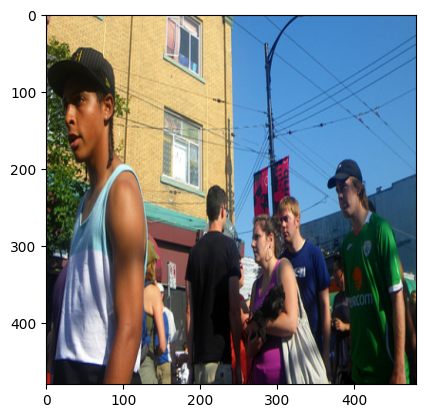

In [8]:
xx = resize(tot_images[4],(480,480))
plt.imshow(xx)

Three UNO cards in reds and yellows in the foreground , with a young boy holding additional cards in the background .


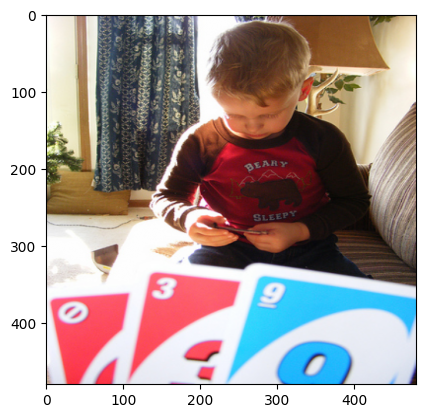

In [43]:
plt.imshow(tot_images[10])
print(corresponding_captions[10])

In [12]:
for x in capts_dt.values():
    print(x)
    break

A little girl in a pink dress going into a wooden cabin .


In [5]:
def build_vocabulary(captions):
    word_dict = {}
    reverse_word_dict = {}
    
    i = 0
    max_sent_size = -float('inf')
    
    frequency = {}
        
    for sent in captions:
        words = word_tokenize(sent)
        
        
        
        if(len(words)>max_sent_size):
            max_sent_size = len(words)
            
        for w in words:
            
            if(len(w)<2):
                continue
                
            if(w in frequency):
                frequency[w] += 1
            else:
                frequency[w] = 1
            
            if(w in word_dict):
                continue
            word_dict[w] = i
            reverse_word_dict[i] = w
            i += 1
        
    sorted_frequency = list(frequency.items())
    sorted_frequency.sort(key = lambda x:x[1])
    
    print(len(word_dict))
    
    for w,f in sorted_frequency[:-10000]:
        word_dict.pop(w)
        
        
    word_dict["<STR>"] = i 
    reverse_word_dict[i] = "<STR>"
    
    word_dict["<END>"] = i+1
    reverse_word_dict[i+1] = "<END>"
    
    word_dict["<PAD>"] = i+2
    reverse_word_dict[i+2] = "<PAD>"
    
    
    
    return word_dict,reverse_word_dict,max_sent_size


def tokenize(captions,word_dict):
    
    tokenized_capts = []
    
    for sent in captions:
        words = word_tokenize(sent)
        cur_sent = [word_dict["<STR>"]]
        for w in words:
            if(w not in word_dict):
                continue
            cur_sent.append(word_dict[w])
        cur_sent.append(word_dict["<END>"])
        
        tokenized_capts.append(cur_sent + [word_dict["<PAD>"]] * (max_sent_size + 3 - len(cur_sent)))
            
    return tokenized_capts

word_dict,reverse_word_dict,max_sent_size= build_vocabulary(corresponding_captions)
tokenized_capts = tokenize(corresponding_captions,word_dict)
            
tokenized_capts = np.array(tokenized_capts)
print(tokenized_capts.shape,len(word_dict))     


4800
(8091, 41) 4803


In [45]:
reverse_word_dict[4825]

'<END>'

In [9]:
onehot_capts = tf.one_hot(tokenized_capts, len(word_dict))
onehot_capts_numpy = onehot_capts.numpy()

In [10]:
print(onehot_capts.shape)

(8091, 41, 4803)


In [ ]:
base_model2 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
out_dum = base_model2(tot_images[0:1])
print(out_dum.shape)

inception_encodes = []
for x in tot_images:
    inp = np.expand_dims(x, axis = 0)
    inception_encodes.append(base_model2(inp).numpy()[0].reshape(36,2048))
    
inception_encodes = np.array(inception_encodes)
print(inception_encodes.shape)

In [106]:

def positional_encoding(length = 2048, depth = 512):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbeddingCapts(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, indicator):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
        self.indicator = indicator

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
                
    # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    
class PositionalEmbeddingImages(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, indicator):
        super().__init__()
        self.d_model = d_model
#         self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)
        self.indicator = indicator

#     def compute_mask(self, *args, **kwargs):
#         return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]                
    # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
#         print(self.pos_encoding[tf.newaxis, :length, :].shape)
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    
    


class create_encoder_block(keras.Model):
    def __init__(self,dns,activ,**kwargs):
        super(create_encoder_block,self).__init__(**kwargs)
        self.attention_self = keras.layers.MultiHeadAttention(8,dns)
        self.norm1 = keras.layers.LayerNormalization()
        self.add = keras.layers.Add()
        self.dense = keras.layers.Dense(dns,activation = activ)
        self.norm2 = keras.layers.LayerNormalization()
        
    def call(self,inp):
        
        self_att_vecs,self_att_scores = self.attention_self(inp,inp,return_attention_scores = True)
        
        residual_vals1 = self.add([inp,self_att_vecs])
        
        normalized_resids1 = self.norm1(residual_vals1)
        
        dense_outs = self.dense(normalized_resids1)
        
        residual_vals2 = self.add([dense_outs,normalized_resids1])
        
        normalized_resids2 = self.norm2(residual_vals2)
        
        return normalized_resids2
    
class create_decoder_block(keras.Model):
    def __init__(self,dns,activ,**kwargs):
        super(create_decoder_block,self).__init__(**kwargs)
        self.attention_self = keras.layers.MultiHeadAttention(8,dns)
        self.attention_cross = keras.layers.MultiHeadAttention(8,dns)
        self.add = keras.layers.Add()
        self.dense = keras.layers.Dense(dns,activation = activ)
        self.norm1 = keras.layers.LayerNormalization()
        self.norm2 = keras.layers.LayerNormalization()
        self.norm3 = keras.layers.LayerNormalization()
        
    def call(self,dec_inp,enc_out):
        
        self_att_vecs,self_att_scores = self.attention_self(dec_inp,dec_inp,use_causal_mask = True,return_attention_scores = True)
        
        resids_self = self.add([self_att_vecs,dec_inp])
        
        normalized_self = self.norm1(resids_self)
        
        cross_att_vecs,cross_att_scores = self.attention_cross(normalized_self,enc_out,return_attention_scores = True)
        
        resids_cross = self.add([cross_att_vecs,normalized_self])
        
        normalized_cross = self.norm2(resids_cross)
        
        feed_forward = self.dense(normalized_cross)
        
        resids_3 = self.add([normalized_cross,feed_forward])
        
        normalized_3 = self.norm3(resids_3)
        
        
        return normalized_3
    
    

class create_encoder_stack(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,**kwargs):
        super(create_encoder_stack,self).__init__()
        self.enc_stk = []
        for i in range(enc_stk_len):
            self.enc_stk.append(create_encoder_block(dns,activ))
            
    def call(self,inp):
        x = inp
        for enc_block in self.enc_stk:
            x = enc_block(x)
            
        return x
            
class create_decoder_stack(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,**kwargs):
        super(create_decoder_stack,self).__init__()
        self.dec_stk = []
        for i in range(enc_stk_len):
            self.dec_stk.append(create_decoder_block(dns,activ))
            
    def call(self,dec_inp,enc_out):
        x = dec_inp
        for dec_block in self.dec_stk:
            x = dec_block(x,enc_out)
#         self.att_scores = 
            
        return x
            

class transformer(keras.Model):
    def __init__(self,dns,activ,enc_stk_len,dec_stk_len,linear_proj_len,**kwargs):
        super(transformer,self).__init__(**kwargs)
        
        
        self.enc_stk = create_encoder_stack(linear_proj_len,activ,enc_stk_len)
        self.dec_stk = create_decoder_stack(dns,activ,dec_stk_len)
        
        self.linear_proj = keras.layers.Dense(linear_proj_len)
    
        self.img_pos_encoder = PositionalEmbeddingImages(len(word_dict),linear_proj_len,0)
        self.capts_pos_encoder = PositionalEmbeddingCapts(len(word_dict),dns,1)
        
            
        self.softmax = keras.layers.Dense(len(word_dict),activation = "softmax")
  
    def call(self,inp,out):
        
        lin_projs = self.linear_proj(inp)
        img_pos_embs = self.img_pos_encoder(lin_projs)
        

        enc_out = self.enc_stk(img_pos_embs)
        
        capts_pos_embs = self.capts_pos_encoder(out)

        dec_out = self.dec_stk(capts_pos_embs,enc_out)
        
        out = self.softmax(dec_out)


        return out
        
                

def train_transformer(pos_xx,pos_yy,yy,model):
    feat_x = copy.deepcopy(pos_xx)        #input features of images
    tok_y = copy.deepcopy(pos_yy)        #tokenized captions
    ohv_y = copy.deepcopy(yy)            #onehot vectors of captions
    tot_losses = []
    print("training started")
    for x in range(epochs):
        ep_loss = 0
        index = 0
        while(index<len(yy)):
            d = feat_x[index:index+batch_size]
            y = tok_y[index:index+batch_size]
            loss_y = ohv_y[index:index+batch_size]
            inds = np.arange(0,min(batch_size,len(d)))
#             print(inds)
            np.random.shuffle(inds)
            d = d[inds]
            y = y[inds]
            loss_y = loss_y[inds]
            index += batch_size
            with tf.GradientTape() as tp:
                pred = model(d,y[:,:-1])
                ls = loss(loss_y[:,1:,:],pred)
            grads = tp.gradient(ls,model.trainable_weights) 
            optim.apply_gradients(zip(grads,model.trainable_weights))
            ep_loss += ls
#             print(ep_loss)
        print("epoch : ", x, "loss : ", ep_loss/(len(feat_x)/batch_size))
        tot_losses.append(ep_loss/(len(feat_x)/batch_size))
    return tot_losses


def get_date_trans(inp,model):
            
        
        tokens = [word_dict["<STR>"]]

#         nex_pos_enc = pos(np.expand_dims(np.array(tokens),axis = 0))
        nex_pos_enc = model.capts_pos_encoder(np.expand_dims(np.array(tokens),axis = 0))
    
        lin_projs = model.linear_proj(inp)
        img_pos_embs = model.img_pos_encoder(lin_projs)
        
        enc_out = model.enc_stk(img_pos_embs)
        
        ch = '<STR>'
        cnt = 0
        t_att_scores11 = []
        t_att_scores21 = []
        t_att_scores31 = []
        
        t_att_scores12,t_att_scores22,t_att_scores32 = [],[],[]
        
        ans = [ch]
        
        result_scores = []
        
        while(ch != "<END>"):
            
            if(cnt == 35):
                break
            cnt += 1
            
            dec_out = model.dec_stk(nex_pos_enc,enc_out)
            
#             result_scores.append(model.dec_stk.att_scores)

            out = model.softmax(dec_out) 
            
            ind = tf.argmax(out[:,-1:,:],axis = 2)
            ch = reverse_word_dict[int(ind)]
            ans.append(ch)
            print(ch)
            tokens.append(ind[0][0])
#             cur_tokens.append(ind[0][0])
            
            nex_pos_enc = model.capts_pos_encoder(np.expand_dims(np.array(tokens),axis = 0))
#             nex_pos_enc = pos(np.expand_dims(np.array(tokens),axis = 0))
   
        
        return " ".join(ans[1:]),result_scores,[t_att_scores11,t_att_scores21,t_att_scores31], [t_att_scores12,t_att_scores22,t_att_scores32]
 

In [ ]:
# ******************************************************************
# **************Training for 500 epochs **************************
# *****************************************************************

In [107]:
epochs = 500
batch_size = 128
linear_proj_len = 512

optim = keras.optimizers.Adagrad()
loss = keras.losses.CategoricalCrossentropy()

trans_model_2 = transformer(linear_proj_len,"gelu",4,4,linear_proj_len)

losses = train_transformer(inception_encodes[:8000],tokenized_capts[:8000],onehot_capts_numpy[:8000],trans_model_2)


training started
epoch :  0 loss :  tf.Tensor(2.8600814, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(2.1772158, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(2.0594158, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(1.9792162, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(1.9198012, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(1.8726451, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(1.834567, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(1.803497, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(1.7777057, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(1.7558726, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(1.7370245, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(1.7204537, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(1.7056426, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(1.6922251, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(1.6799327, shape=(), dtype=float32)
epoch

The
man
is
wearing
blue
shirt
and
blue
shirt
and
blue
shirt
<END>
The man is wearing blue shirt and blue shirt and blue shirt <END>
The man is wearing a black shirt and holding up a blue item in a window .


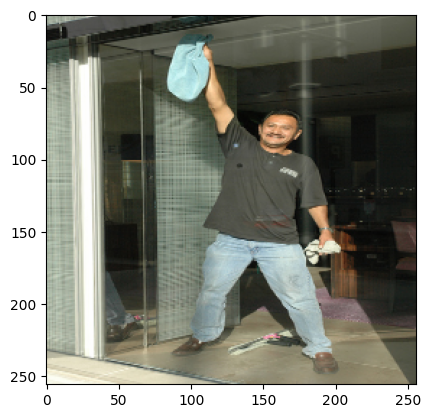

In [108]:
       
x = 1000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


Two
men
are
playing
with
the
camera
<END>
Two men are playing with the camera <END>
The man is walking with a young child outside .


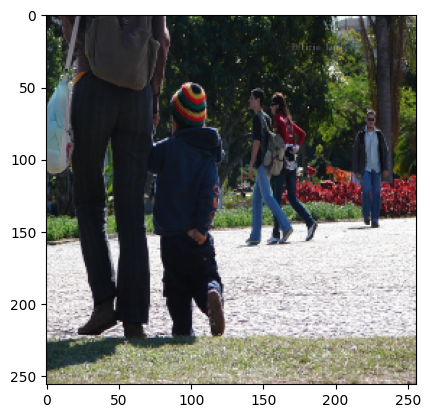

In [109]:
       
x = 2000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


The
man
is
wearing
red
shirt
and
white
and
white
and
white
and
white
and
white
and
white
and
white
and
white
and
white
and
white
and
white
shirt
is
standing
on
the
air
on
The man is wearing red shirt and white and white and white and white and white and white and white and white and white and white and white shirt is standing on the air on
The boy is skateboarding on the stairs .


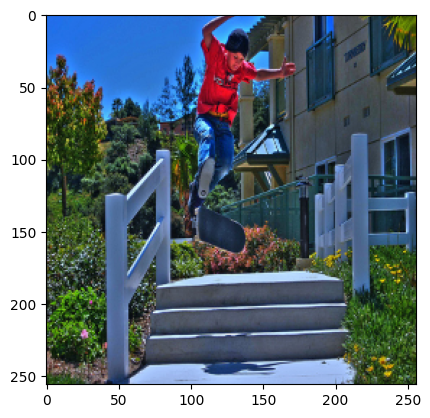

In [110]:
       
x = 3000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


Two
men
are
playing
in
the
ball
<END>
Two men are playing in the ball <END>
Two young men play basketball while crowd looks on


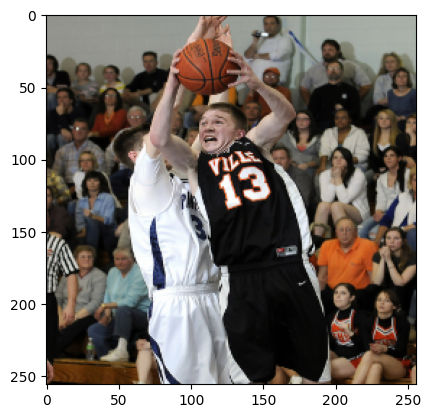

In [111]:
       
x = 4000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


In [ ]:
# ******************************************************************
# **************Training for another 500 epochs **************************
# *****************************************************************

In [112]:
losses = train_transformer(inception_encodes[:8000],tokenized_capts[:8000],onehot_capts_numpy[:8000],trans_model_2)


training started
epoch :  0 loss :  tf.Tensor(1.101535, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(1.101128, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(1.1007215, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(1.1003156, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(1.0999097, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(1.0995034, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(1.0990986, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(1.0986935, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(1.0982889, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(1.0978849, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(1.0974811, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(1.0970768, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(1.0966733, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(1.0962707, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(1.0958673, shape=(), dtype=float32)
epoch

The
man
is
wearing
blue
shirt
and
blue
shirt
and
blue
shirt
with
his
mouth
<END>
The man is wearing blue shirt and blue shirt and blue shirt with his mouth <END>
The man is wearing a black shirt and holding up a blue item in a window .


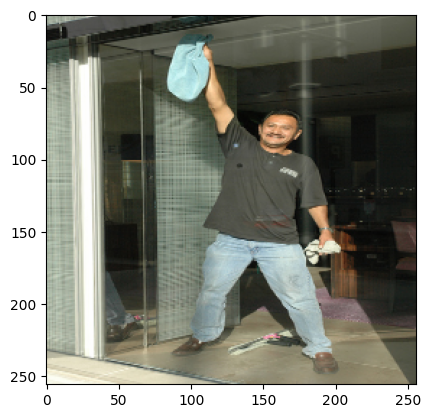

In [113]:
       
x = 1000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


The
man
is
wearing
black
and
black
and
black
dog
<END>
The man is wearing black and black and black dog <END>
The man is walking with a young child outside .


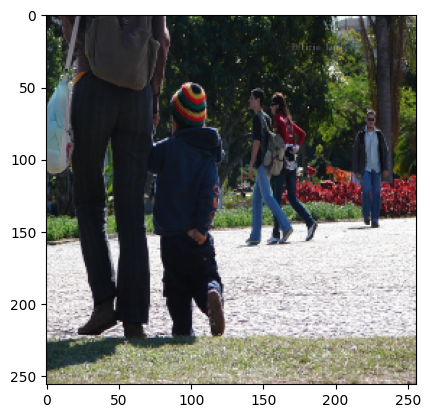

In [114]:
       
x = 2000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


The
skateboarder
is
jumping
over
the
air
<END>
The skateboarder is jumping over the air <END>
The boy is skateboarding on the stairs .


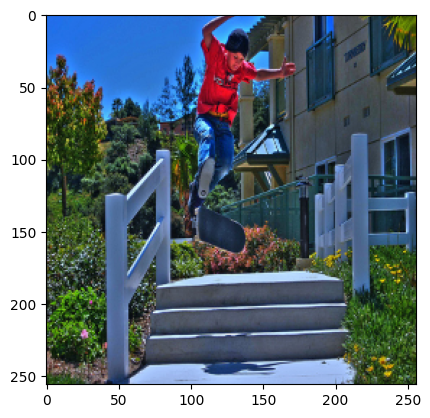

In [115]:
       
x = 3000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


Two
men
are
playing
basketball
and
one
is
in
the
basketball
<END>
Two men are playing basketball and one is in the basketball <END>
Two young men play basketball while crowd looks on


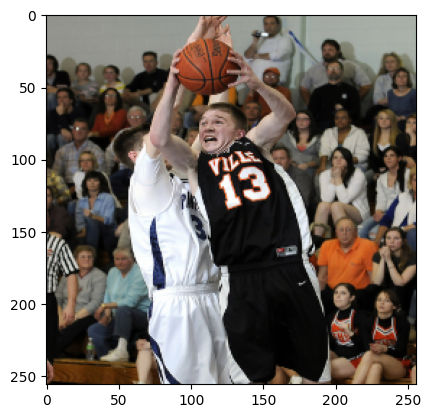

In [116]:
       
x = 4000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


In [ ]:
# ******************************************************************
# **************Training for another 500 epochs **************************
# *****************************************************************

In [117]:
losses = train_transformer(inception_encodes[:8000],tokenized_capts[:8000],onehot_capts_numpy[:8000],trans_model_2)


training started
epoch :  0 loss :  tf.Tensor(0.8880427, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.8846679, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.8855221, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.8874647, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.88758177, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.88357836, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.8835691, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.88412166, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.8847383, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.88238716, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.88215566, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.8827259, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.8814748, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.8802405, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.87960386, shape=(), dtype=float3

Two
men
sitting
on
bench
by
the
water
with
people
sitting
on
bench
by
the
background
<END>
Two men sitting on bench by the water with people sitting on bench by the background <END>
Two people sitting on a dock under a lamp post with clouds in the sky beyond them .


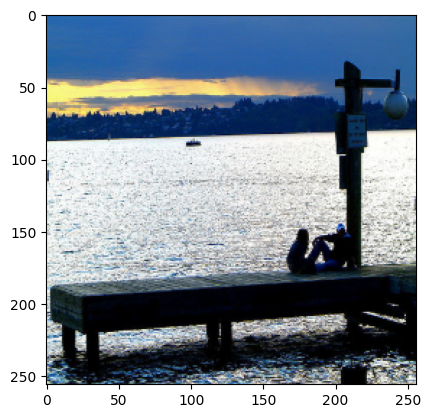

In [119]:
       
x = 100

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


Two
brown
dogs
run
through
the
grass
near
brown
dog
<END>
Two brown dogs run through the grass near brown dog <END>
Two brown dogs run along a gravel road while another dog watches .


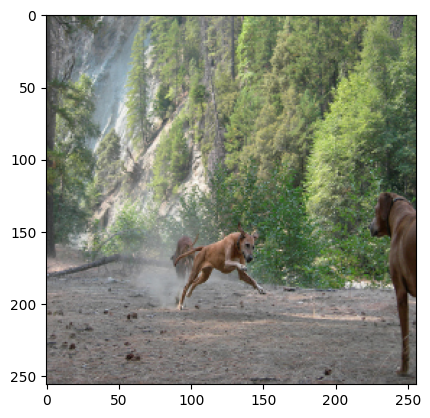

In [125]:
       
x = 1005

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


In [ ]:
# ******************************************************************
# **************Training for another 500 epochs **************************
# *****************************************************************

In [126]:
losses = train_transformer(inception_encodes[:8000],tokenized_capts[:8000],onehot_capts_numpy[:8000],trans_model_2)


training started
epoch :  0 loss :  tf.Tensor(0.6745736, shape=(), dtype=float32)
epoch :  1 loss :  tf.Tensor(0.6746013, shape=(), dtype=float32)
epoch :  2 loss :  tf.Tensor(0.6734457, shape=(), dtype=float32)
epoch :  3 loss :  tf.Tensor(0.67135954, shape=(), dtype=float32)
epoch :  4 loss :  tf.Tensor(0.67049986, shape=(), dtype=float32)
epoch :  5 loss :  tf.Tensor(0.6714309, shape=(), dtype=float32)
epoch :  6 loss :  tf.Tensor(0.6718432, shape=(), dtype=float32)
epoch :  7 loss :  tf.Tensor(0.67433524, shape=(), dtype=float32)
epoch :  8 loss :  tf.Tensor(0.67554367, shape=(), dtype=float32)
epoch :  9 loss :  tf.Tensor(0.67226005, shape=(), dtype=float32)
epoch :  10 loss :  tf.Tensor(0.6685368, shape=(), dtype=float32)
epoch :  11 loss :  tf.Tensor(0.6676092, shape=(), dtype=float32)
epoch :  12 loss :  tf.Tensor(0.6692259, shape=(), dtype=float32)
epoch :  13 loss :  tf.Tensor(0.67035705, shape=(), dtype=float32)
epoch :  14 loss :  tf.Tensor(0.6725035, shape=(), dtype=float3

The
man
is
wearing
black
shirt
and
holding
up
blue
shirt
is
holding
up
<END>
The man is wearing black shirt and holding up blue shirt is holding up <END>
The man is wearing a black shirt and holding up a blue item in a window .


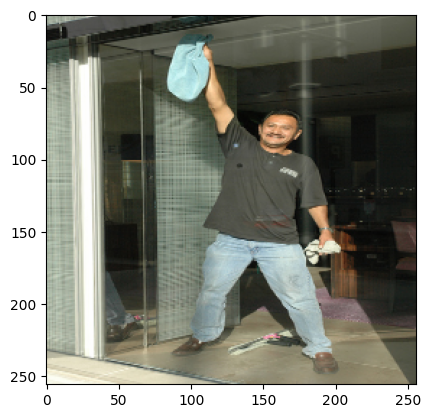

In [131]:
       
x = 1000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


The
man
is
walking
with
young
child
with
the
street
<END>
The man is walking with young child with the street <END>
The man is walking with a young child outside .


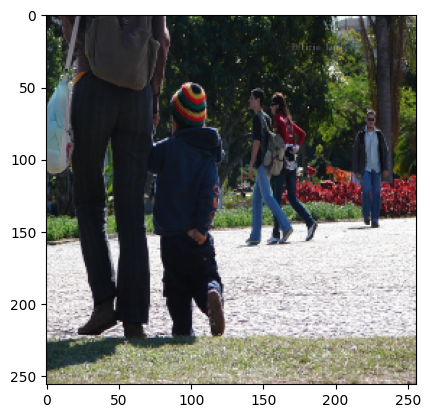

In [132]:
       
x = 2000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


The
boy
is
doing
the
slide
on
<END>
The boy is doing the slide on <END>
The boy is skateboarding on the stairs .


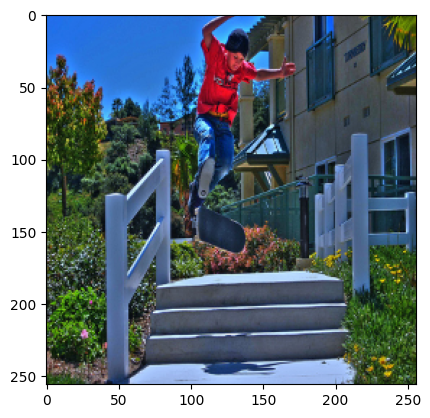

In [133]:
       
x = 3000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


Two
young
men
play
basketball
while
another
young
<END>
Two young men play basketball while another young <END>
Two young men play basketball while crowd looks on


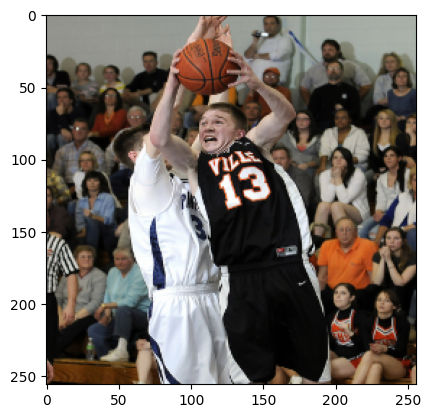

In [134]:
       
x = 4000

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption)
print(corresponding_captions[x])


In [ ]:
# ******************************************************************
# **************Testing captions for unseeen data (only 8000 images are used for training) **************************
# *****************************************************************

dog
jumping
the
water
<END>
dog jumping the water <END>
A large black dog is jumping off a pier into a pond .


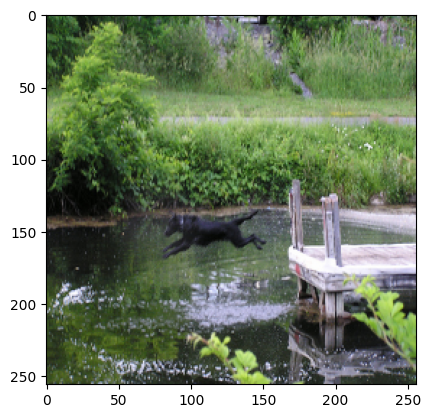

In [140]:
       
x = 8010

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption[:])
print(corresponding_captions[x])


The
large
brown
dog
is
jumping
on
the
with
his
mouth
<END>
The large brown dog is jumping on the with his mouth <END>
Dog with toy in mouth jumps over bar decorated with prize ribbons .


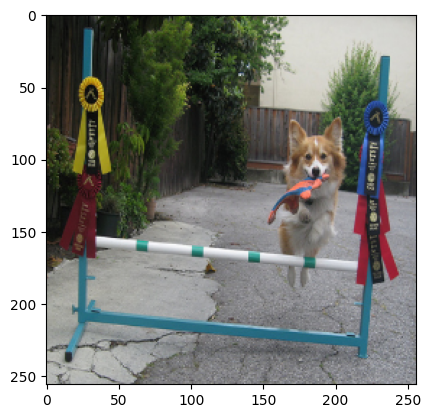

In [141]:
       
x = 8020

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption[:])
print(corresponding_captions[x])


Three
people
stand
with
bike
at
the
camera
and
standing
at
the
camera
while
standing
at
the
camera
<END>
Three people stand with bike at the camera and standing at the camera while standing at the camera <END>
The boy with the red and blue helmet rides his bicycle .


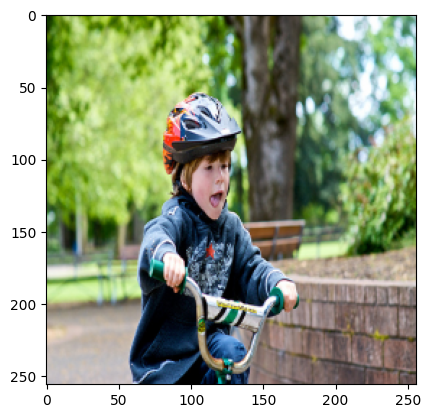

In [142]:
       
x = 8030

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption[:])
print(corresponding_captions[x])


person
on
bike
is
riding
in
the
air
on
bike
<END>
person on bike is riding in the air on bike <END>
A person rides a motorbike on a dirt path surrounded by trees .


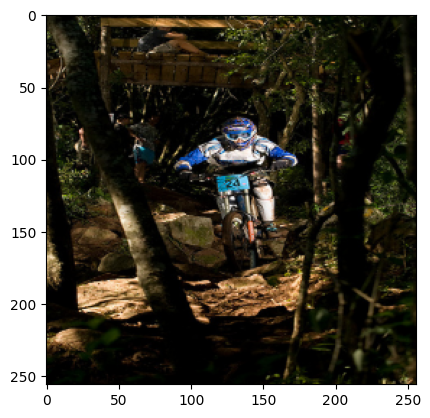

In [146]:
       
x = 8070

plt.imshow(tot_images[x])
output_caption,cross_scores,result_scores,self_scores = get_date_trans(inception_encodes[x:x+1],trans_model_2)  
print(output_caption[:])
print(corresponding_captions[x])
